In [6]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path

import ipytest

CODE_FOLDER = Path("code")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "../../data/penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [4]:
import boto3
import sagemaker
S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

print(region)

us-east-1


In [7]:
import pandas as pd
import numpy as np

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## 1. Write code to identify any potential outliers in the dataset. An outlier is a data point that differs significantly from other observations.

In [8]:
# we mainly have two kind of outlires
# Incategorical data, outlires are rare values or low frequency values

### Categorical outliers 

In [9]:
penguins['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

No outlier in species because all categories have enough values

In [10]:
penguins['island'].value_counts()

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

Same here too. No outliers

### Numerical outliers

#### Descriptive stats

In [11]:
penguins.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [14]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [16]:
# lets do the analysis for outliers in numeric feature using iqr

def display_outliers(penguins, feature_name):
    q1 =  penguins[feature_name].quantile(0.25)
    q3 =  penguins[feature_name].quantile(0.75)

    iqr = q3 -q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers = penguins[(penguins[feature_name] <lower_bound) |  (penguins[feature_name] > upper_bound)]
    display(outliers)

num_fields = penguins.select_dtypes(exclude=['object']).columns

for field_name in num_fields:
    display_outliers(penguins=penguins, feature_name=field_name)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


#### Box Plots

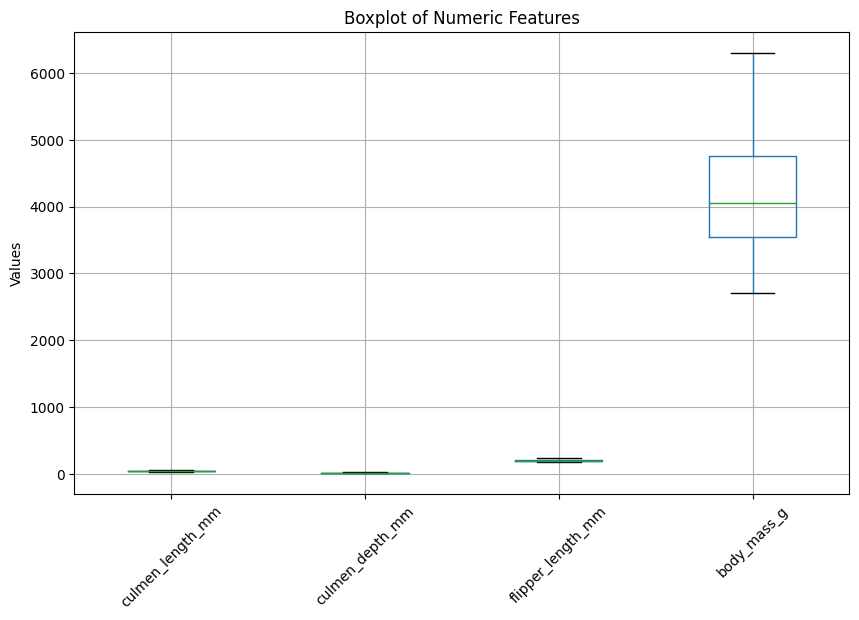

In [21]:
import matplotlib.pyplot as plt

# Boxplot for all numeric columns
plt.figure(figsize=(10, 6))  # Set the figure size
penguins.boxplot(showfliers=True)  # Plot boxplots for all numeric columns
plt.title('Boxplot of Numeric Features')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

<Figure size 1000x600 with 0 Axes>

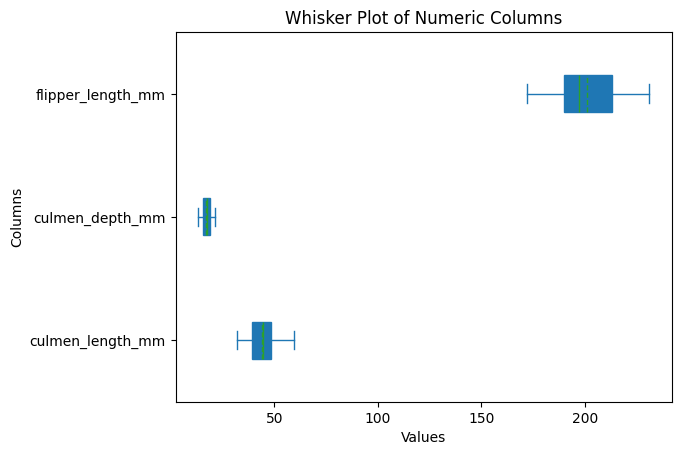

In [20]:
plt.figure(figsize=(10, 6))  # Set the figure size
penguins.drop('body_mass_g', axis=1).plot(kind='box', vert=False, patch_artist=True, meanline=True, showmeans=True)  # Plot whisker plot for all numeric columns
plt.title('Whisker Plot of Numeric Columns')
plt.xlabel('Values')
plt.ylabel('Columns')
plt.show()

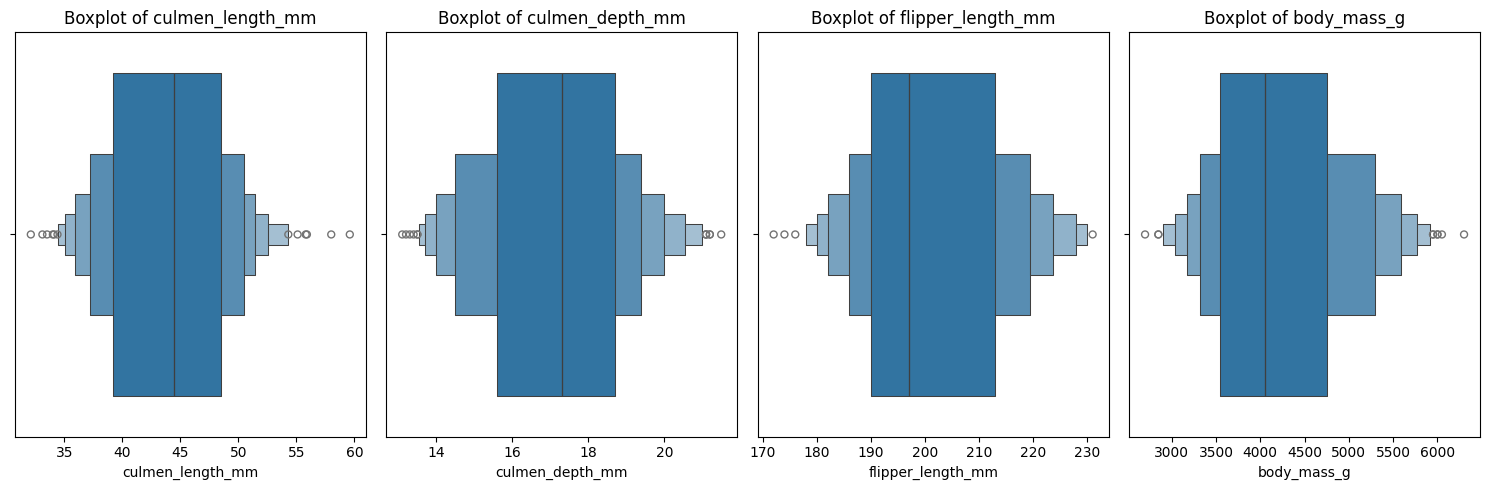

In [48]:
import seaborn as sns

penguins_num = penguins.drop(['species','island','sex'],axis=1)
# Create subplots for each numerical feature
fig, axes = plt.subplots(nrows=1, ncols=len(penguins_num.columns), figsize=(15, 5))

# Iterate through columns and create box plots
for i, col in enumerate(penguins_num.columns):
    sns.boxenplot(x=col, data=penguins_num, ax=axes[i])
    axes[i].set_title('Boxplot of ' + col)

plt.tight_layout()
plt.show()

<Axes: >

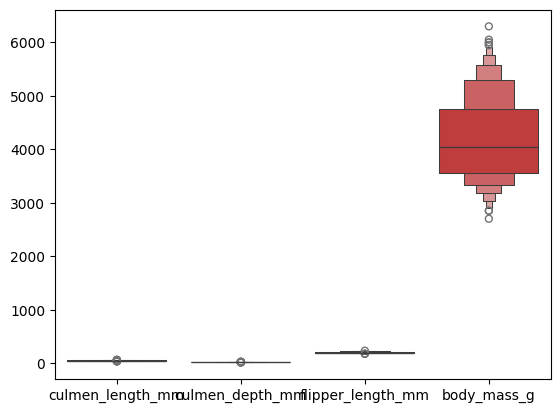

In [44]:


sns.boxenplot(penguins)

#### Z Score

Any data point outside third standard deviation is an outlier. So if zscore for a value is > 3 or < -3 , thats an outlier

In [39]:
penguins.dropna(axis=0)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [41]:
from scipy import stats

penguins_nona = penguins.dropna(axis=0)
penguins_nona['z_score_body_mass_g'] = stats.zscore(penguins_nona['body_mass_g'])

display(penguins_nona)
outliers = penguins_nona[abs(penguins_nona['z_score_body_mass_g']) > 3]
display(outliers)

C:\Users\hemch\AppData\Local\Temp\ipykernel_29124\3972587530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_nona['z_score_body_mass_g'] = stats.zscore(penguins_nona['body_mass_g'])


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,z_score_body_mass_g
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,-0.571229
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,-0.509011
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,-1.193405
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,-0.944535
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,-0.695664
...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,0.890886
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,0.797560
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE,1.917477
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,1.233083


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,z_score_body_mass_g


In [43]:
penguins_nona['z_score_body_mass_g'].describe()

count    3.340000e+02
mean    -1.276424e-16
std      1.001500e+00
min     -1.877800e+00
25%     -8.200995e-01
50%     -1.979229e-01
75%      7.275647e-01
max      2.601872e+00
Name: z_score_body_mass_g, dtype: float64

# 2. Write code to determine whether the sex column has predictive power for the species column.

In [49]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


The basic test used to calculate predictive power of a categorical variable on another categorical variable in chisquare test

In [50]:
penguines_cleaned = penguins.dropna(axis=0)

contingency_table = pd.crosstab(penguines_cleaned['sex'],penguines_cleaned['species']) 
contingency_table


species,Adelie,Chinstrap,Gentoo
sex,,,
.,0,0,1
FEMALE,73,34,58
MALE,73,34,61


Contingency table does not show any predictive power but lets still doa chi square test

In [51]:
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print('chi2',chi2)
print('p_value',p_value)

chi2 1.837180735930736
p_value 0.7656733509960999


In [52]:
threshold_for_significance = 0.05

if p_value < threshold_for_significance:
    print("Has predictive power")
else:
    print("No Predictive power")

No Predictive power


In [53]:
# Lets do a similar excercise for island

contingency_table_island = pd.crosstab(penguines_cleaned['island'],penguines_cleaned['species']) 
contingency_table_island


species,Adelie,Chinstrap,Gentoo
island,,,
Biscoe,44,0,120
Dream,55,68,0
Torgersen,47,0,0


Looks like there is some predictive power.

In [54]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table_island)

print('chi2',chi2)
print('p_value',p_value)

if p_value < threshold_for_significance:
    print("Has predictive power")
else:
    print("No Predictive power")

chi2 285.8287114377993
p_value 1.2336388683938059e-60
Has predictive power


# 3. Write code to visualize or quantify the predictive strength of every feature in the dataset.

In [55]:
# Lets do this using information gain

In [82]:
penguins_nona = penguins.dropna(axis=0)

In [83]:
penguins_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [84]:
penguins_nona.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [97]:
from sklearn.preprocessing import OneHotEncoder

df = penguins_nona.copy()
df['sex'].replace({'.' : 'MALE'}, inplace=True)
columns_to_encode = ['island','sex']

cat_columns_df = df[columns_to_encode]


encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(cat_columns_df)

encoded_columns = encoder.get_feature_names_out(input_features=columns_to_encode)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=cat_columns_df.index)

# display(encoded_df)

df_all_and_encoded = pd.concat([df, encoded_df], axis=1)
display(df_all_and_encoded)

C:\Users\hemch\AppData\Local\Temp\ipykernel_29124\4029659004.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sex'].replace({'.' : 'MALE'}, inplace=True)


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,island_Dream,island_Torgersen,sex_MALE
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,0.0,1.0,1.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,0.0,1.0,0.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,0.0,1.0,0.0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,0.0,1.0,0.0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,0.0,0.0,0.0
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,0.0,0.0,0.0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE,0.0,0.0,1.0
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,0.0,0.0,0.0


In [98]:
# Select columns to be one-hot encoded

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target column
df_all_and_encoded['species_encoded'] = label_encoder.fit_transform(df['species'])
df_all_and_encoded


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,island_Dream,island_Torgersen,sex_MALE,species_encoded
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,0.0,1.0,1.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,0.0,1.0,0.0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,0.0,1.0,0.0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,0.0,1.0,0.0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,0.0,0.0,0.0,2
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,0.0,0.0,0.0,2
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE,0.0,0.0,1.0,2
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,0.0,0.0,0.0,2


In [102]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
scaled_features = scaler.fit_transform(df_all_and_encoded[columns_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=columns_to_scale, index=df_all_and_encoded.index)

df_all_and_encoded.drop(columns_to_scale, axis=1, inplace=True)

df_all_scaled = pd.concat([df_all_and_encoded, scaled_df], axis=1)
display(df_all_scaled)

,species,island,sex,island_Dream,island_Torgersen,sex_MALE,species_encoded,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Torgersen,MALE,0.0,1.0,1.0,0,0.254545,0.666667,0.152542,0.291667
1,Adelie,Torgersen,FEMALE,0.0,1.0,0.0,0,0.269091,0.511905,0.237288,0.305556
2,Adelie,Torgersen,FEMALE,0.0,1.0,0.0,0,0.298182,0.583333,0.389831,0.152778
4,Adelie,Torgersen,FEMALE,0.0,1.0,0.0,0,0.167273,0.738095,0.355932,0.208333
5,Adelie,Torgersen,MALE,0.0,1.0,1.0,0,0.261818,0.892857,0.305085,0.263889
...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,FEMALE,0.0,0.0,0.0,2,0.549091,0.071429,0.711864,0.618056
340,Gentoo,Biscoe,FEMALE,0.0,0.0,0.0,2,0.534545,0.142857,0.728814,0.597222
341,Gentoo,Biscoe,MALE,0.0,0.0,1.0,2,0.665455,0.309524,0.847458,0.847222
342,Gentoo,Biscoe,FEMALE,0.0,0.0,0.0,2,0.476364,0.202381,0.677966,0.694444


In [104]:
# lets apply OHE on categorical features and then feature scaling on all other numerical features

final_training_df = df_all_scaled[['culmen_length_mm', 'culmen_depth_mm','flipper_length_mm', 'body_mass_g','island_Dream','island_Torgersen','sex_MALE','species_encoded']]
display(final_training_df)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE,species_encoded
0,0.254545,0.666667,0.152542,0.291667,0.0,1.0,1.0,0
1,0.269091,0.511905,0.237288,0.305556,0.0,1.0,0.0,0
2,0.298182,0.583333,0.389831,0.152778,0.0,1.0,0.0,0
4,0.167273,0.738095,0.355932,0.208333,0.0,1.0,0.0,0
5,0.261818,0.892857,0.305085,0.263889,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...
338,0.549091,0.071429,0.711864,0.618056,0.0,0.0,0.0,2
340,0.534545,0.142857,0.728814,0.597222,0.0,0.0,0.0,2
341,0.665455,0.309524,0.847458,0.847222,0.0,0.0,1.0,2
342,0.476364,0.202381,0.677966,0.694444,0.0,0.0,0.0,2


In [105]:
# Now lets check information gain

from sklearn.feature_selection import mutual_info_classif

X_scaled = final_training_df.drop('species_encoded', axis=1)
y = final_training_df['species_encoded']
mutual_info = mutual_info_classif(X_scaled, y)
mutual_info

array([0.55399953, 0.56468839, 0.61067157, 0.50233973, 0.33690974,
       0.11804767, 0.05278209])

<Axes: >

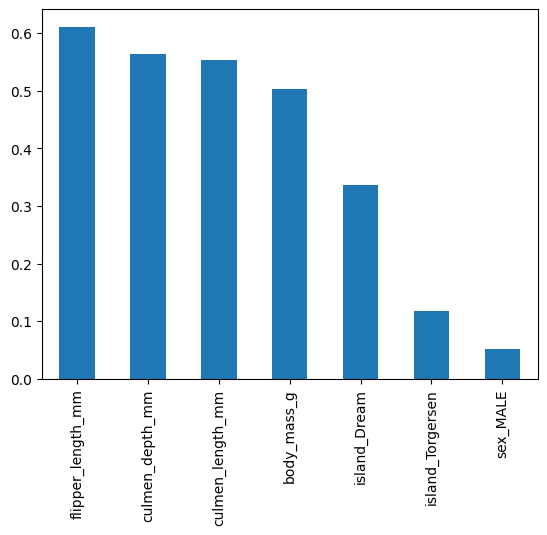

In [106]:
mutual_info_ser = pd.Series(mutual_info)
mutual_info_ser.index = X_scaled.columns
mutual_info_ser.sort_values(ascending=False).plot.bar()

### Solve this using Feature importance of a decision tree

In [109]:
from sklearn.model_selection import train_test_split
X_scaled = final_training_df.drop('species_encoded', axis=1)
y = final_training_df['species_encoded']
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, random_state=23, test_size=0.3) # never do this (scaling features before split). here its for feture importance only

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        36

    accuracy                           0.99       101
   macro avg       0.98      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



In [111]:
feature_importance = clf.feature_importances_
print("Feature Importance:", feature_importance)

Feature Importance: [0.34576528 0.1819517  0.22890159 0.11937246 0.09858847 0.01968695
 0.00573355]


<Axes: >

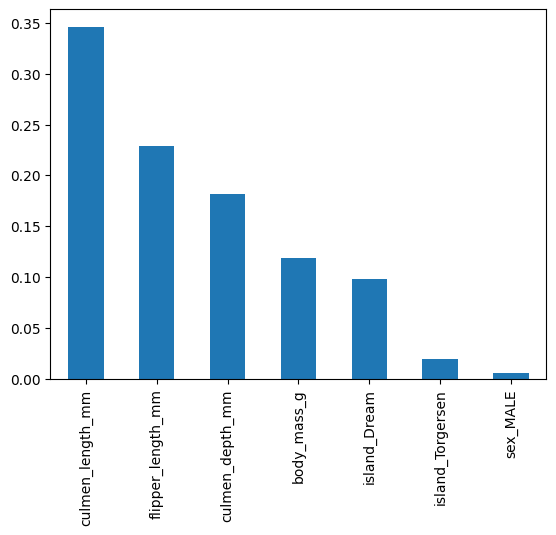

In [112]:
feature_importance_ser = pd.Series(feature_importance)
feature_importance_ser.index = X_scaled.columns
feature_importance_ser.sort_values(ascending=False).plot.bar()

Same results here too. We can do this in a cleaner way though

In [114]:
#from sklearn import metrics
#fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
#roc_auc = metrics.auc(fpr, tpr)
#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Random Forest')
#display.plot()
#plt.show()